In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

## Text Regression with Extra Regressors: An Example of Using Custom Data Formats and Models in *ktrain*

This notebook illustrates how one can construct custom data formats and models for use in *ktrain*.  In this example, we will build a model that can predict the price of a wine by **both** its textual description and the winery from which it was produced. This example is inspired by [FloydHub's regression template](https://github.com/floydhub/regression-template) for wine price prediction. However, instead of using the wine variety as the extra regressor, we will use the winery.

Text classification (or text regression) with extra predictors arises across many scenarios.  For instance, when making a prediction about the trustworthiness of a news story, one may want to consider both the text of the news aricle in addition to extra metadata such as the news publication and the authors. Here, such models can be built.

The dataset in CSV format can be obtained from Floydhub at [this URL](https://www.floydhub.com/floydhub/datasets/wine-reviews/1/wine_data.csv).  We will begin by importing some necessary modules and reading in the dataset.

In [2]:
# import some modules and read in the dataset
import pandas as pd
from tensorflow import keras
import numpy as np
import math
path = 'data/wine/wine_data.csv'  # ADD path/to/dataset
data = pd.read_csv(path)
data = data.sample(frac=1., random_state=42)
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
82956,82956,Spain,Spiced apple and dried cheese aromas are simul...,Mercat Brut,84,12.0,Catalonia,Cava,NaN,Sparkling Blend,El Xamfrà
60767,60767,US,"A little too sharp and acidic, with jammy cher...",NaN,82,9.0,California,California,California Other,Shiraz,Woodbridge by Robert Mondavi
123576,123576,Spain,"Starts out rustic and leathery, with hints of ...",Selección 12 Crianza,89,15.0,Levante,Jumilla,NaN,Red Blend,Bodegas Luzón
71003,71003,Chile,Ripe to the point that it's soft and flat. Big...,NaN,82,8.0,Maule Valley,NaN,NaN,Chardonnay,Melania
78168,78168,Italy,From one of the best producers in the little-t...,Contado Riserva,88,17.0,Southern Italy,Molise,NaN,Aglianico,Di Majo Norante


## Cleaning the Data

We use the exact same data-cleaning steps employed in [FloydHub's regression example](https://github.com/floydhub/regression-template) for this dataset.

In [3]:
# Clean it from null values
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['price'])]
data = data.drop(data.columns[0], axis=1) 
variety_threshold = 500 # Anything that occurs less than this will be removed.
value_counts = data['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
data.replace(to_remove, np.nan, inplace=True)
data = data[pd.notnull(data['variety'])]
data = data[pd.notnull(data['winery'])]

# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

# Train features
description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

# Train labels
labels_train = data['price'][:train_size]

# Test features
description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

# Test labels
labels_test = data['price'][train_size:]

x_train = description_train.values
y_train = labels_train.values
x_test = description_test.values
y_test = labels_test.values

# winery  metadata to be used later
winery_train = data['winery'][:train_size]
winery_test = data['winery'][train_size:]

Train size: 95612
Test size: 23904


## Building a Vanilla Text Regression Model in *ktrain*

We will preprocess the data and select a `linreg` model for our initial "vanilla" text regression model.

In [4]:
import ktrain
from ktrain import text

using Keras version: 2.2.4-tf


In [5]:
trn, val, preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                          x_test=x_test, y_test=y_test,
                                          ngram_range=3, 
                                          maxlen=200, 
                                          max_features=35000)

task: text regression (supply class_names argument if this is supposed to be classification task)
language: en
Word Counts: 30807
Nrows: 95612
95612 train sequences
train sequence lengths:
	mean : 41
	95percentile : 62
	99percentile : 74
Adding 3-gram features
max_features changed to 1765149 with addition of ngrams
Average train sequence length with ngrams: 120
train (w/ngrams) sequence lengths:
	mean : 121
	95percentile : 183
	99percentile : 219
x_train shape: (95612,200)
y_train shape: 95612
23904 test sequences
test sequence lengths:
	mean : 41
	95percentile : 62
	99percentile : 74
Average test sequence length with ngrams: 111
test (w/ngrams) sequence lengths:
	mean : 112
	95percentile : 171
	99percentile : 207
x_test shape: (23904,200)
y_test shape: 23904


In [6]:
text.print_text_regression_models()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
linreg: linear text regression using a trainable Embedding layer
bigru: Bidirectional GRU with pretrained word vectors [https://arxiv.org/abs/1712.09405]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face [https://arxiv.org/abs/1910.01108]


In [7]:
model = text.text_regression_model('linreg', train_data=trn, preproc=preproc)

maxlen is 200
done.


## Adding an Extra Regressor to Our Model

Next, we will add an extra regressor to our model, thereby, creating a new, augmented model.  We choose the winery as the extra regressor, which is a categorical variable.  Instead of representing the winery as a typical one-hot-encoded vector, we will learn an embedding for the winery during training.  The embedding module will then be concatenated with our `linreg` text regression model forming a new model.  The new model expects two distinct inputs.  The first input is an integer representing the winery.  The second input is a sequence of word IDs - standard input to neural text classifiers/regressors.

In [8]:
extra_train_data = winery_train
extra_test_data = winery_test

# encode winery as integers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['winery'])
extra_train = encoder.transform(extra_train_data)
extra_test = encoder.transform(extra_test_data)
no_of_unique_cat = np.max(extra_train) + 1
embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
embedding_size = int(embedding_size)
vocab =  no_of_unique_cat+1
print(embedding_size)
extra_train = np.expand_dims(extra_train, -1)
extra_test = np.expand_dims(extra_test, -1)

# winery module
extra_input = keras.layers.Input(shape=(1,))
extra_output = keras.layers.Embedding(vocab, embedding_size, input_length=1)(extra_input)
extra_output = keras.layers.Flatten()(extra_output)
extra_model = keras.Model(inputs=extra_input, outputs=extra_output)
extra_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Combine winery module with linreg model
merged_out = keras.layers.concatenate([extra_model.output, model.output])
merged_out = keras.layers.Dropout(0.25)(merged_out)
merged_out = keras.layers.Dense(1000, activation='relu')(merged_out)
merged_out = keras.layers.Dropout(0.25)(merged_out)
merged_out = keras.layers.Dense(500, activation='relu')(merged_out)
merged_out = keras.layers.Dropout(0.5)(merged_out)
merged_out = keras.layers.Dense(1)(merged_out)
combined_model = keras.Model([extra_model.input] + [model.input], merged_out)
combined_model.compile(loss='mae',
                       optimizer='adam',
                      metrics=['mae'])

50


## Wrapping our Data in an Instance of `ktrain.Dataset`
To use this custom data format of two inputs in *ktrain*, we will wrap it in a `ktrain.Dataset` instance, which is simply a `tf.keras` Sequence wrapper.  We must be sure to override and implment the required methods (e.g., `def nsamples` and `def get_y`).  The `ktrain.Dataset` class is simply a subclass of `tf.keras.utils.Sequence`.  See the TensorFlow documentation on the [Sequence class](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) for more information on how Sequence wrappers work.

Note that, in the implementation below, we have made `MyCustomDataset` more general such that it can wrap lists containing an arbitrary number of inputs instead of just the two needed in our example. 

In [9]:
class MyCustomDataset(ktrain.Dataset):
    def __init__(self, x, y, batch_size=32, shuffle=True):
        # error checks
        err = False
        if type(x) == np.ndarray and len(x.shape) != 2: err = True
        elif type(x) == list:
            for d in x:
                if type(d) != np.ndarray or len(d.shape) != 2:
                    err = True
                    break
        else: err = True
        if err:
            raise ValueError('x must be a 2d numpy array or a list of 2d numpy arrays')
        if type(y) != np.ndarray:
            raise ValueError('y must be a numpy array')
        if type(x) == np.ndarray:
            x = [x]

        # set variables
        super().__init__(batch_size=batch_size)
        self.x, self.y = x, y
        self.indices = np.arange(self.x[0].shape[0])
        self.n_inputs = len(x)
        self.shuffle = shuffle

    # required for instances of tf.keras.utils.Sequence
    def __len__(self):
        return math.ceil(self.x[0].shape[0] / self.batch_size)

    # required for instances of tf.keras.utils.Sequence
    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = []
        for i in range(self.n_inputs):
            batch_x.append(self.x[i][inds])
        batch_y = self.y[inds]
        return tuple(batch_x), batch_y

    # required for instances of ktrain.Dataset
    def nsamples(self):
        return self.x[0].shape[0]

    #required for instances of ktrain.Dataset
    def get_y(self):
        return self.y

    def on_epoch_end(self):
        if self.shuffle:  np.random.shuffle(self.indices)

## Using the Custom Model and Data Format

Once we wrap our data in a `ktrain.Dataset` instance, we can wrap the model and datasets in a `Learner` object and use *ktrain* normally.

In [10]:
train_data = MyCustomDataset([extra_train] +  [trn[0]], trn[1], shuffle=True)
val_data = MyCustomDataset([extra_test] + [val[0]], val[1], shuffle=False)
learner = ktrain.get_learner(combined_model, train_data=train_data, val_data=val_data, batch_size=256)

### Estimate Learning Rate

We'll choose a learning rate where the loss is falling. As shown in the plot, *1e-3* seems to be a good choice in this case.

simulating training for different learning rates... this may take a few moments...
Train for 373 steps
Epoch 1/1024
373/373 [==============================] - 9s 24ms/step - loss: 34.1117 - mae: 34.1153
Epoch 2/1024
373/373 [==============================] - 8s 20ms/step - loss: 28.8677 - mae: 28.8826
Epoch 3/1024
373/373 [==============================] - 8s 20ms/step - loss: 13.2890 - mae: 13.2908
Epoch 4/1024
373/373 [==============================] - 8s 21ms/step - loss: 20.4389 - mae: 20.4431
Epoch 5/1024
359/373 [===========================>..] - ETA: 0s - loss: 17.9780 - mae: 17.9780

done.


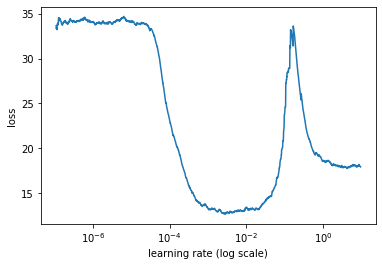

In [11]:
learner.lr_find(show_plot=True)

### Train the Model

We will now train the model using the estimated learning rate from above for 12 epochs using the [1cycle learning rate policy](https://arxiv.org/pdf/1803.09820.pdf).

In [12]:
learner.fit_onecycle(1e-3, 12)



begin training using onecycle policy with max lr of 0.001...
Train for 374 steps, validate for 94 steps
Epoch 1/12
374/374 [==============================] - 9s 23ms/step - loss: 22.8788 - mae: 22.8866 - val_loss: 13.7107 - val_mae: 13.7028
Epoch 2/12
374/374 [==============================] - 9s 23ms/step - loss: 12.2521 - mae: 12.2531 - val_loss: 10.8341 - val_mae: 10.8276
Epoch 3/12
374/374 [==============================] - 9s 23ms/step - loss: 9.9158 - mae: 9.9183 - val_loss: 9.9131 - val_mae: 9.9106
Epoch 4/12
374/374 [==============================] - 8s 23ms/step - loss: 8.9252 - mae: 8.9264 - val_loss: 9.4691 - val_mae: 9.4692
Epoch 5/12
374/374 [==============================] - 8s 23ms/step - loss: 8.3064 - mae: 8.3072 - val_loss: 9.1714 - val_mae: 9.1709
Epoch 6/12
374/374 [==============================] - 8s 22ms/step - loss: 7.9027 - mae: 7.9037 - val_loss: 9.0367 - val_mae: 9.0353
Epoch 7/12
374/374 [==============================] - 9s 23ms/step - loss: 7.4723 - mae:

Our final validation MAE is **7.82**, which means our predictions are, on average, about $8 off the mark, which is not bad considering our model only looks at the textual description of the wine and the winery.

### Plot Some Training History

The validation loss is still decreasing, which suggests we could train further if desired.  The second and third plot show the learning rate and momentum schedules employed by `fit_onecycle`.

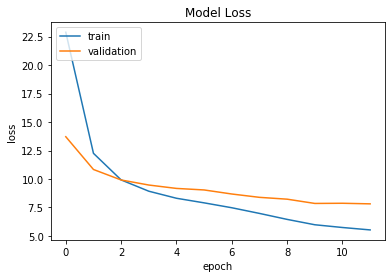

In [13]:
learner.plot('loss')

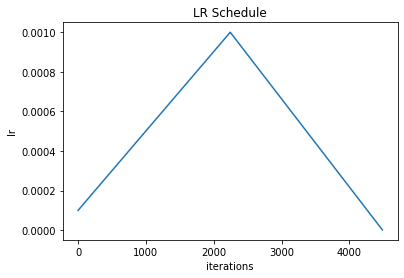

In [14]:
learner.plot('lr')

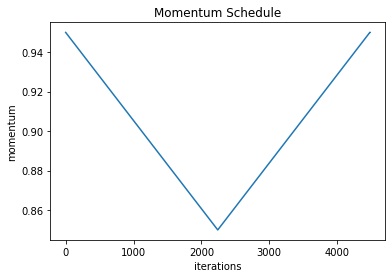

In [15]:
learner.plot('momentum')

### View Top Losses

Let's examine the validation examples that we got the most wrong.  Looks like our model has trouble with expensive wines.

In [16]:
learner.view_top_losses(n=3)

----------
id:21790 | loss:1042.46 | true:1100.0 | pred:57.54)

----------
id:13745 | loss:1014.34 | true:1400.0 | pred:385.66)

----------
id:11710 | loss:884.58 | true:980.0 | pred:95.42)



In [17]:
print(x_test[21790])

Wet earth, rain-wet stones, damp moss, wild sage and very ripe pear make for a complex opening. Further sniffs reveal more citrus: both juice and zest of lemon. The palate still holds a lot of leesy yeast flavors but its phenolic richness is tempered by total citrus freshness. This is still tightly wound; leave it so it can come into its own. The warming resonance on the palate suggests it has a long future. Drink from 2019.


In [18]:
print(x_test[13745])

A wine that has created its own universe. It has a unique, special softness that allies with the total purity that comes from a small, enclosed single vineyard. The fruit is almost irrelevant here, because it comes as part of a much deeper complexity. This is a great wine, at the summit of Champagne, a sublime, unforgettable experience.


In [19]:
preds = learner.predict(val_data)

In [20]:
preds[13745]

array([385.65793], dtype=float32)

### Making Predictions

Lastly, we will use our model to make predictions on 5 randomly selected wines in the validation set.

In [22]:
# 5 random predictions
val_data.batch_size = 1
for i in range(5):
    idx = np.random.choice(len(x_test))
    print("TEXT:\n%s" % (x_test[idx]))
    print()
    print("\tpredicted: %s" % (np.squeeze(learner.predict(val_data[idx]))))
    print("\tactual: %s" % (y_test[idx]))           
    print('----------------------------------------')

TEXT:
Relatively full-bodied and muscular as well as dry, this new effort from winemaker Steve Bird features plenty of brawny citrus and spice flavors that finish long. There's no real track record, so it's probably best to drink now.

	predicted: 18.009167
	actual: 17.0
----------------------------------------
TEXT:
Very tart and spicy, with distinct notes of clove and orange peel. Citrus and apple flavors crop up unexpectedly, and the tannins have a hint of green tea about them.

	predicted: 20.4764
	actual: 20.0
----------------------------------------
TEXT:
Dusty apple aromas are given lift courtesy of citrus notes. This feels good on the palate, with zesty acidity. Flavors of stone fruits, tropical fruits, apple and citrus meld together well, while the finish is pure and long.

	predicted: 15.768029
	actual: 17.0
----------------------------------------
TEXT:
Smoky and savory on the nose, with saucy fruit sitting below a veil of firm oak. Runs a bit tart and racy in the mouth, whe

Let's look at our most expensive prediction.  Our most expensive prediction (`$404`) is associated with an expensive wine priced at `$800`, which is good. However, we are `~$400` off.  Again, our model has trouble with expensive wines.  This is somewhat understandable since our model only looks at short textual descriptions and the winery - neither of which contain clear indicators of their exorbitant prices.

In [43]:
max_pred_id = np.argmax(preds)
print("highest-priced prediction: %s" % (np.squeeze(preds[max_pred_id])))
print("actual price for this wine:%s" % (y_test[max_pred_id]))
print('TEXT:\n%s' % (x_test[max_pred_id]))

highest-priced prediction: 404.31885
actual price for this wine:800.0
TEXT:
The palate opens slowly, offering an initial citrus character, followed by wood and then, finally, wonderfully rich, but taut fruit. There is still a toast character here, with apricots and pear on top of the citrus, but it is still only just developing. In 10–15 years, it will be a magnificent wine.
